<a id='1'></a>
# Autoencoder
* neural network with unsupervised machine-learning algorithm apply back-prop to set target value to the input
* auto-encoder prefers over PCA because it can learn non-linear transformations with non-linear activation functions. more efficient to learn several layer with auto-encoder then one huge transformation with PCA.

<a id='2'></a>
# Autoencoder Applications
* Image coloring (Black-white images -> colored)
* Feature variation (Extract required feature)
* Dimensionality Reduction
* Denosing image (Remove Noise)
* Remove watermark

<a id='3'></a>
# Autoencoder Architecture
* **Encoder** : part of NN compress the input into latent space representation
* **code** : part of NN represents compressed input 
* **Decoder** : Decode the encoded data to original dimension

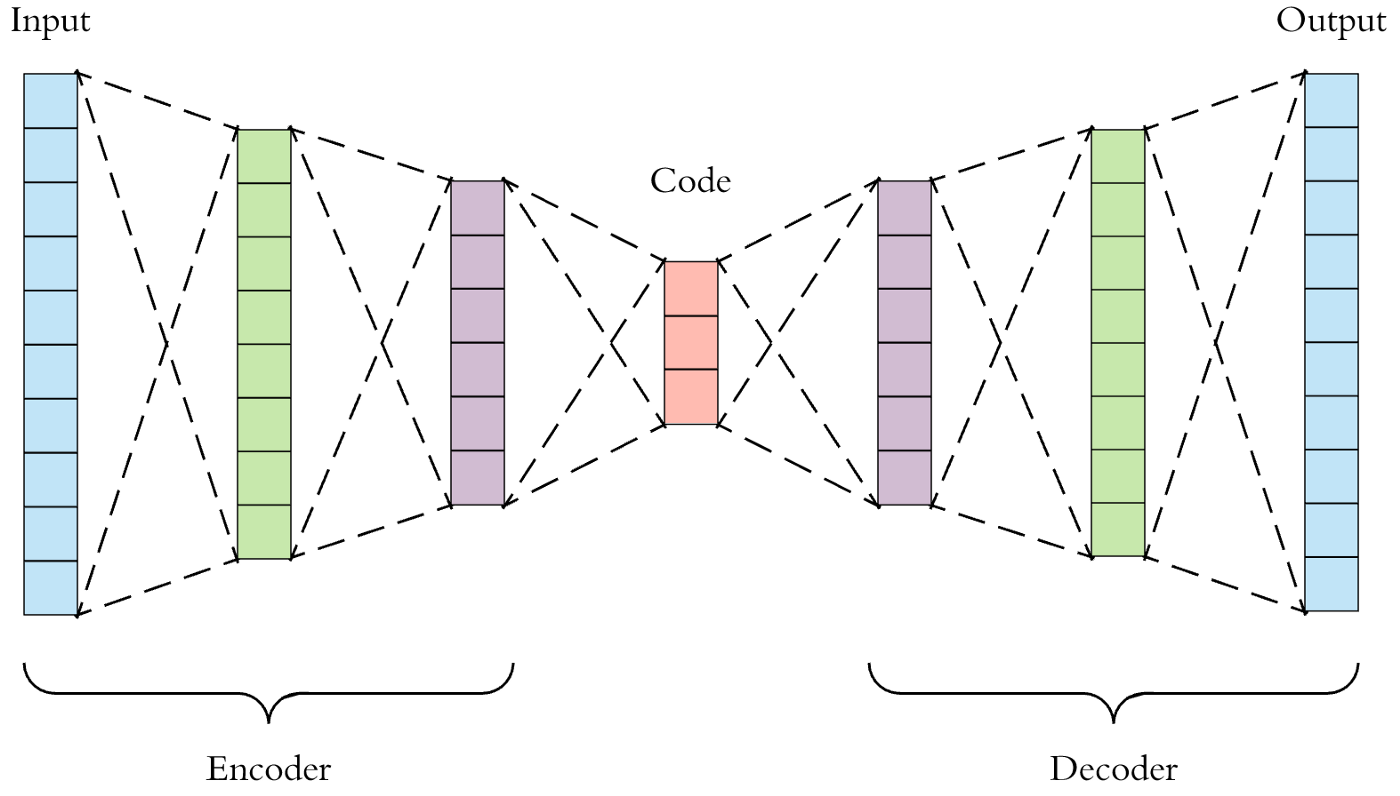

<a id='4'></a>
# Properties of Autoencoder
1. **Data-specific**: Autoencoders are only able to meaningfully compress data similar to what they have been trained on.
2. **Lossy**: de-compressed output will be degrad compared to the original input
3. **Unsupervised**: Autoencoders are considered an unsupervised learning technique since they don’t need explicit labels to train on. But to be more precise they are **self-supervised** because they generate their own labels from the training data.

<a id='5'></a>
# Types of Autoencoder
1.  **Denoising** autoencoder.
2.  **Sparse** Autoencoder.
3.  **Deep** Autoencoder.
4.  **Contractive** Autoencoder.
5.  **Undercomplete** Autoencoder.
6.  **Convolutional** Autoencoder.
7.  **Variational** Autoencoder.

# UnderComplete Autoencoder<a id="vae"></a>


In [4]:
# Import necessary libraries
import numpy as np
import pandas as pd
import os
import cv2

import matplotlib.pyplot as plt
import seaborn as sns
import random

from scipy.stats import norm

import keras
from keras import backend as K
K.clear_session()

In [5]:
# Set parameters for hand gesture recognition dataset
image_shape = (80, 80, 1)  # Adjusted to match your hand gesture images' size and grayscale
batch_size = 64
latent_dim = 16
epochs = 5  # Adjust epochs as needed based on your dataset's complexity and training results

In [6]:
import os
import cv2
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle  # Import the shuffle function
from tensorflow.keras.utils import to_categorical

# Parameters
IMG_SIZE = 80  # Image size to resize to
data_path = '../input/leapgestrecog/leapGestRecog/'  # Path to dataset folder

# Initialize lists to store images and labels
x_data = []
y_data = []

# Dictionaries for label encoding and decoding
lookup = {}
reverselookup = {}
label_count = 0

# Create label mappings based on subfolders
for folder_name in os.listdir(data_path + '00/'):
    if not folder_name.startswith('.'):
        lookup[folder_name] = label_count
        reverselookup[label_count] = folder_name
        label_count += 1

# Load images and labels
for i in range(10):  # Assumes folders named '00' to '09'
    folder_path = f'{data_path}0{i}/'
    for gesture_folder in os.listdir(folder_path):
        if not gesture_folder.startswith('.'):
            for image_file in os.listdir(f'{folder_path}{gesture_folder}/'):
                # Load and resize each image
                img_path = f'{folder_path}{gesture_folder}/{image_file}'
                img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
                
                # Check if image is loaded successfully
                if img is None:
                    print(f"Warning: Image {img_path} could not be loaded.")
                    continue

                # Resize and add to dataset
                img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
                x_data.append(img)
                y_data.append(lookup[gesture_folder])

# Convert lists to numpy arrays and normalize
x_data = np.array(x_data, dtype='float32').reshape(-1, IMG_SIZE, IMG_SIZE, 1) / 255.0
y_data = np.array(y_data)

# One-hot encode labels for classification
y_data = to_categorical(y_data, num_classes=len(lookup))

# Shuffle the dataset
x_data, y_data = shuffle(x_data, y_data, random_state=42)

# Split into training and validation sets (80% train, 20% validation)
x_train, x_val, y_train, y_val = train_test_split(x_data, y_data, test_size=0.2, random_state=42)

# Display dataset info
print("Dataset loaded.")
print(f"Total images: {len(x_data)}")
print(f"Image shape: {x_data[0].shape}")
print(f"Number of classes: {len(lookup)}")

# Optional: Check label mappings
print("Label mappings:", lookup)

# Optional: Check the shapes of the train/validation split
print(f"Training set shape: {x_train.shape}, {y_train.shape}")
print(f"Validation set shape: {x_val.shape}, {y_val.shape}")


Dataset loaded.
Total images: 20000
Image shape: (80, 80, 1)
Number of classes: 10
Label mappings: {'02_l': 0, '04_fist_moved': 1, '09_c': 2, '10_down': 3, '06_index': 4, '08_palm_moved': 5, '07_ok': 6, '05_thumb': 7, '01_palm': 8, '03_fist': 9}
Training set shape: (16000, 80, 80, 1), (16000, 10)
Validation set shape: (4000, 80, 80, 1), (4000, 10)


In [10]:
import numpy as np
import matplotlib.pyplot as plt
 
# Decode one-hot labels to integer labels
y_train_integers = np.argmax(y_train, axis=1)
 
def get_images_1_to_10(x_data, y_data):
    selected_x = []
    selected_y = []
    labels = np.arange(10)
    for label in labels:
        # Find indices of images with the specific label
        label_indices = np.where(y_data == label)[0]
        if len(label_indices) > 0:
            # Select a random image for this label
            random_index = np.random.choice(label_indices)
            selected_x.append(x_data[random_index])
            selected_y.append(y_data[random_index])
        else:
            print(f"No images found for label {label}.")
    return np.array(selected_x), np.array(selected_y)

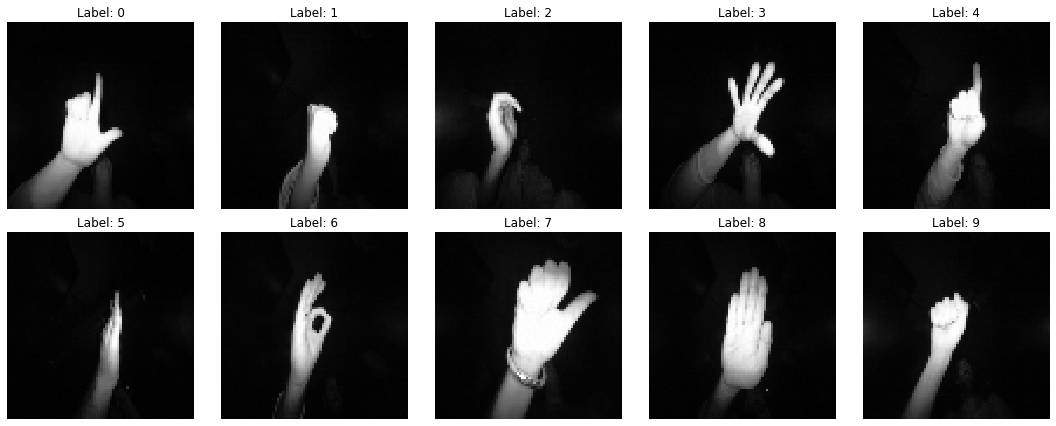

In [11]:
selected_x, selected_y = get_images_1_to_10(x_train, y_train_integers)
 
# Visualize the selected images
fig, axes = plt.subplots(2, 5, figsize=(15, 6))
for ax, img, label in zip(axes.ravel(), selected_x, selected_y):
    ax.imshow(img.reshape(80, 80), cmap='gray')
    ax.set_title(f'Label: {label}')
    ax.axis('off')
 
plt.tight_layout()
plt.show()

In [12]:
from tensorflow.keras import layers, models
import tensorflow as tf

# Define the undercomplete autoencoder with sparsity constraint
def build_autoencoder(input_shape, encoding_dim=32):
    # Encoder
    input_img = layers.Input(shape=input_shape)
    encoded = layers.Dense(encoding_dim, activation='relu', activity_regularizer=tf.keras.regularizers.l1(10e-5))(input_img)

    # Decoder
    decoded = layers.Dense(input_shape[0], activation='sigmoid')(encoded)  # Output shape should match input

    # Autoencoder Model
    autoencoder = models.Model(input_img, decoded)

    # Encoder Model (for obtaining the compressed representation)
    encoder = models.Model(input_img, encoded)

    return autoencoder, encoder

# Build the undercomplete autoencoder model
autoencoder, encoder = build_autoencoder((80 * 80,))  # Input shape is now (784,) # Input shape is 784 (flattened image)

# Compile the autoencoder with a different loss function
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

# Summary of the model to ensure the changes took effect
autoencoder.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 6400)]            0         
_________________________________________________________________
dense (Dense)                (None, 32)                204832    
_________________________________________________________________
dense_1 (Dense)              (None, 6400)              211200    
Total params: 416,032
Trainable params: 416,032
Non-trainable params: 0
_________________________________________________________________


In [13]:
# Flatten the images to match the input shape (784,)
x_train_flat = x_train.reshape(-1, 80 * 80)  # Flatten to (16000, 784)
x_val_flat = x_val.reshape(-1, 80 * 80)  # Flatten to (4000, 784)

# Now you can train the autoencoder
autoencoder.fit(x_train_flat, x_train_flat, 
                epochs=50, 
                batch_size=256, 
                shuffle=True, 
                validation_data=(x_val_flat, x_val_flat))


Train on 16000 samples, validate on 4000 samples
Epoch 1/50
16000/16000 [==============================] - 3s 178us/sample - loss: 0.3693 - val_loss: 0.2657
Epoch 2/50
16000/16000 [==============================] - 2s 133us/sample - loss: 0.2536 - val_loss: 0.2436
Epoch 3/50
16000/16000 [==============================] - 2s 130us/sample - loss: 0.2365 - val_loss: 0.2308
Epoch 4/50
16000/16000 [==============================] - 2s 137us/sample - loss: 0.2265 - val_loss: 0.2237
Epoch 5/50
16000/16000 [==============================] - 2s 135us/sample - loss: 0.2209 - val_loss: 0.2193
Epoch 6/50
16000/16000 [==============================] - 2s 131us/sample - loss: 0.2171 - val_loss: 0.2160
Epoch 7/50
16000/16000 [==============================] - 2s 137us/sample - loss: 0.2143 - val_loss: 0.2136
Epoch 8/50
16000/16000 [==============================] - 2s 147us/sample - loss: 0.2122 - val_loss: 0.2116
Epoch 9/50
16000/16000 [==============================] - 2s 156us/sample - loss: 0.210

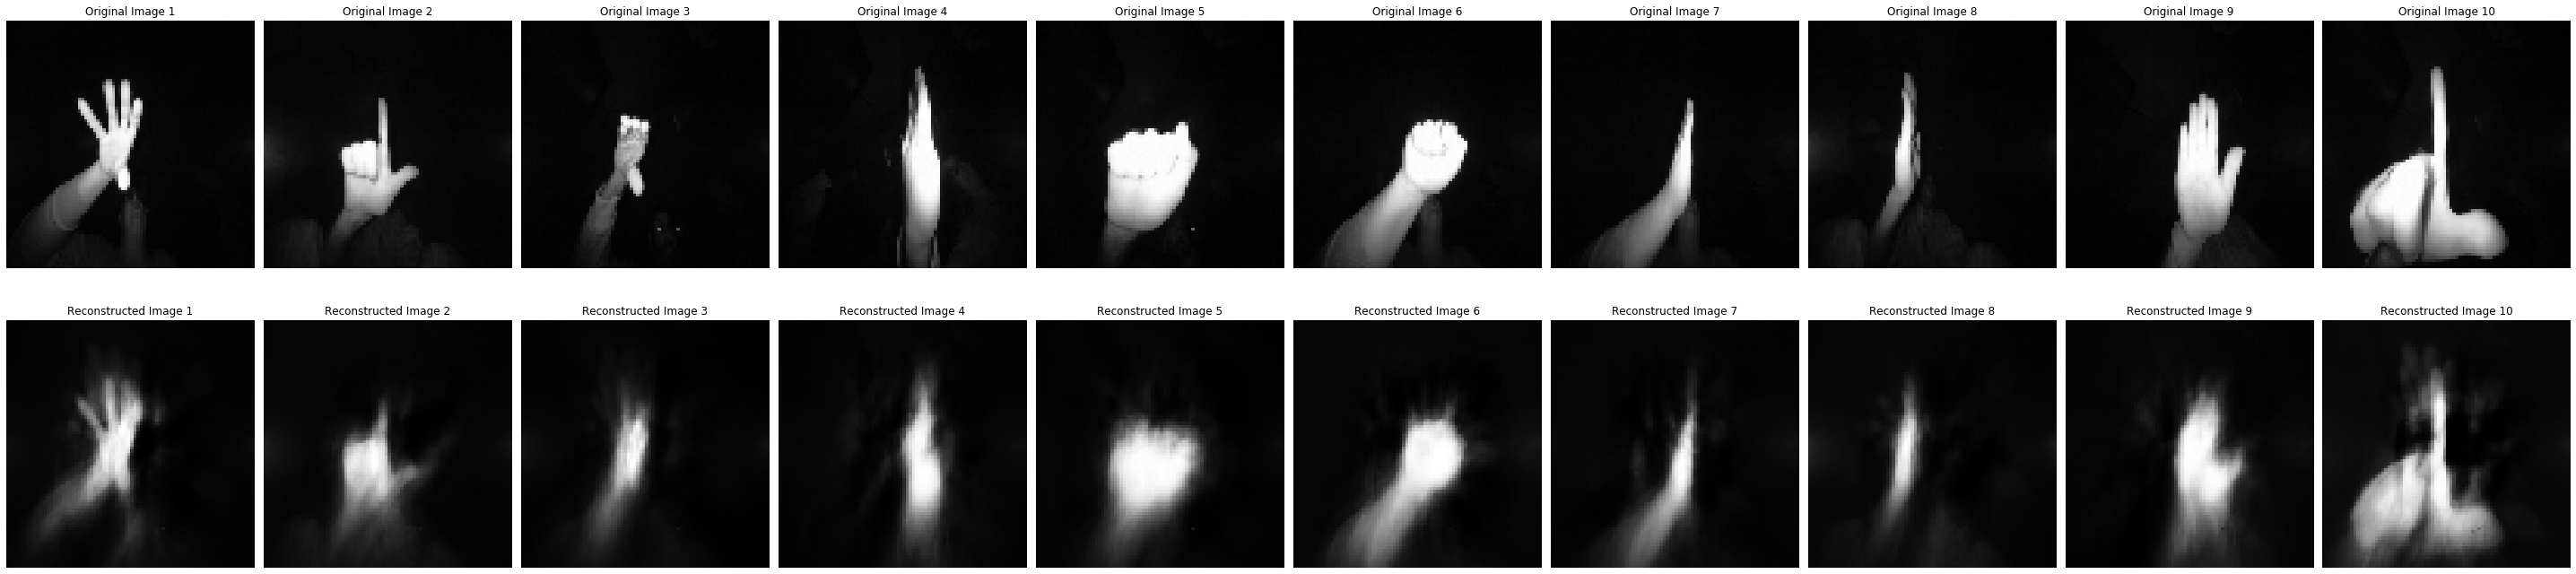

In [14]:
import matplotlib.pyplot as plt

# Set the number of images you want to display
num_images_to_display = 10

# Prepare the plot with a larger figure size
plt.figure(figsize=(40, 10))  # Adjusted figure size to fit vertically

# Loop over the first `num_images_to_display` images from the dataset
for i in range(num_images_to_display):
    # Get the original image from the dataset and reshape it
    original_image = x_data[i].reshape(IMG_SIZE, IMG_SIZE)
    
    # Flatten the image to match the autoencoder's expected input shape (784,)
    flattened_image = original_image.flatten().reshape(1, -1)
    
    # Reconstruct the image using the trained autoencoder
    reconstructed_image = autoencoder.predict(flattened_image).reshape(IMG_SIZE, IMG_SIZE)
    
    # Plot the original image (top row)
    plt.subplot(2, num_images_to_display, i + 1)
    plt.imshow(original_image, cmap='gray')
    plt.title(f"Original Image {i + 1}")
    plt.axis('off')
    
    # Plot the reconstructed image (bottom row)
    plt.subplot(2, num_images_to_display, num_images_to_display + i + 1)
    plt.imshow(reconstructed_image, cmap='gray')
    plt.title(f"Reconstructed Image {i + 1}")
    plt.axis('off')

# Adjust layout to reduce gaps
plt.tight_layout()
plt.show()


Mean Squared Error (MSE): 0.004391377791762352
Mean Absolute Error (MAE): 0.027210896834731102
Average SSIM: 0.880267006361182
Average PSNR: 24.283081413623812


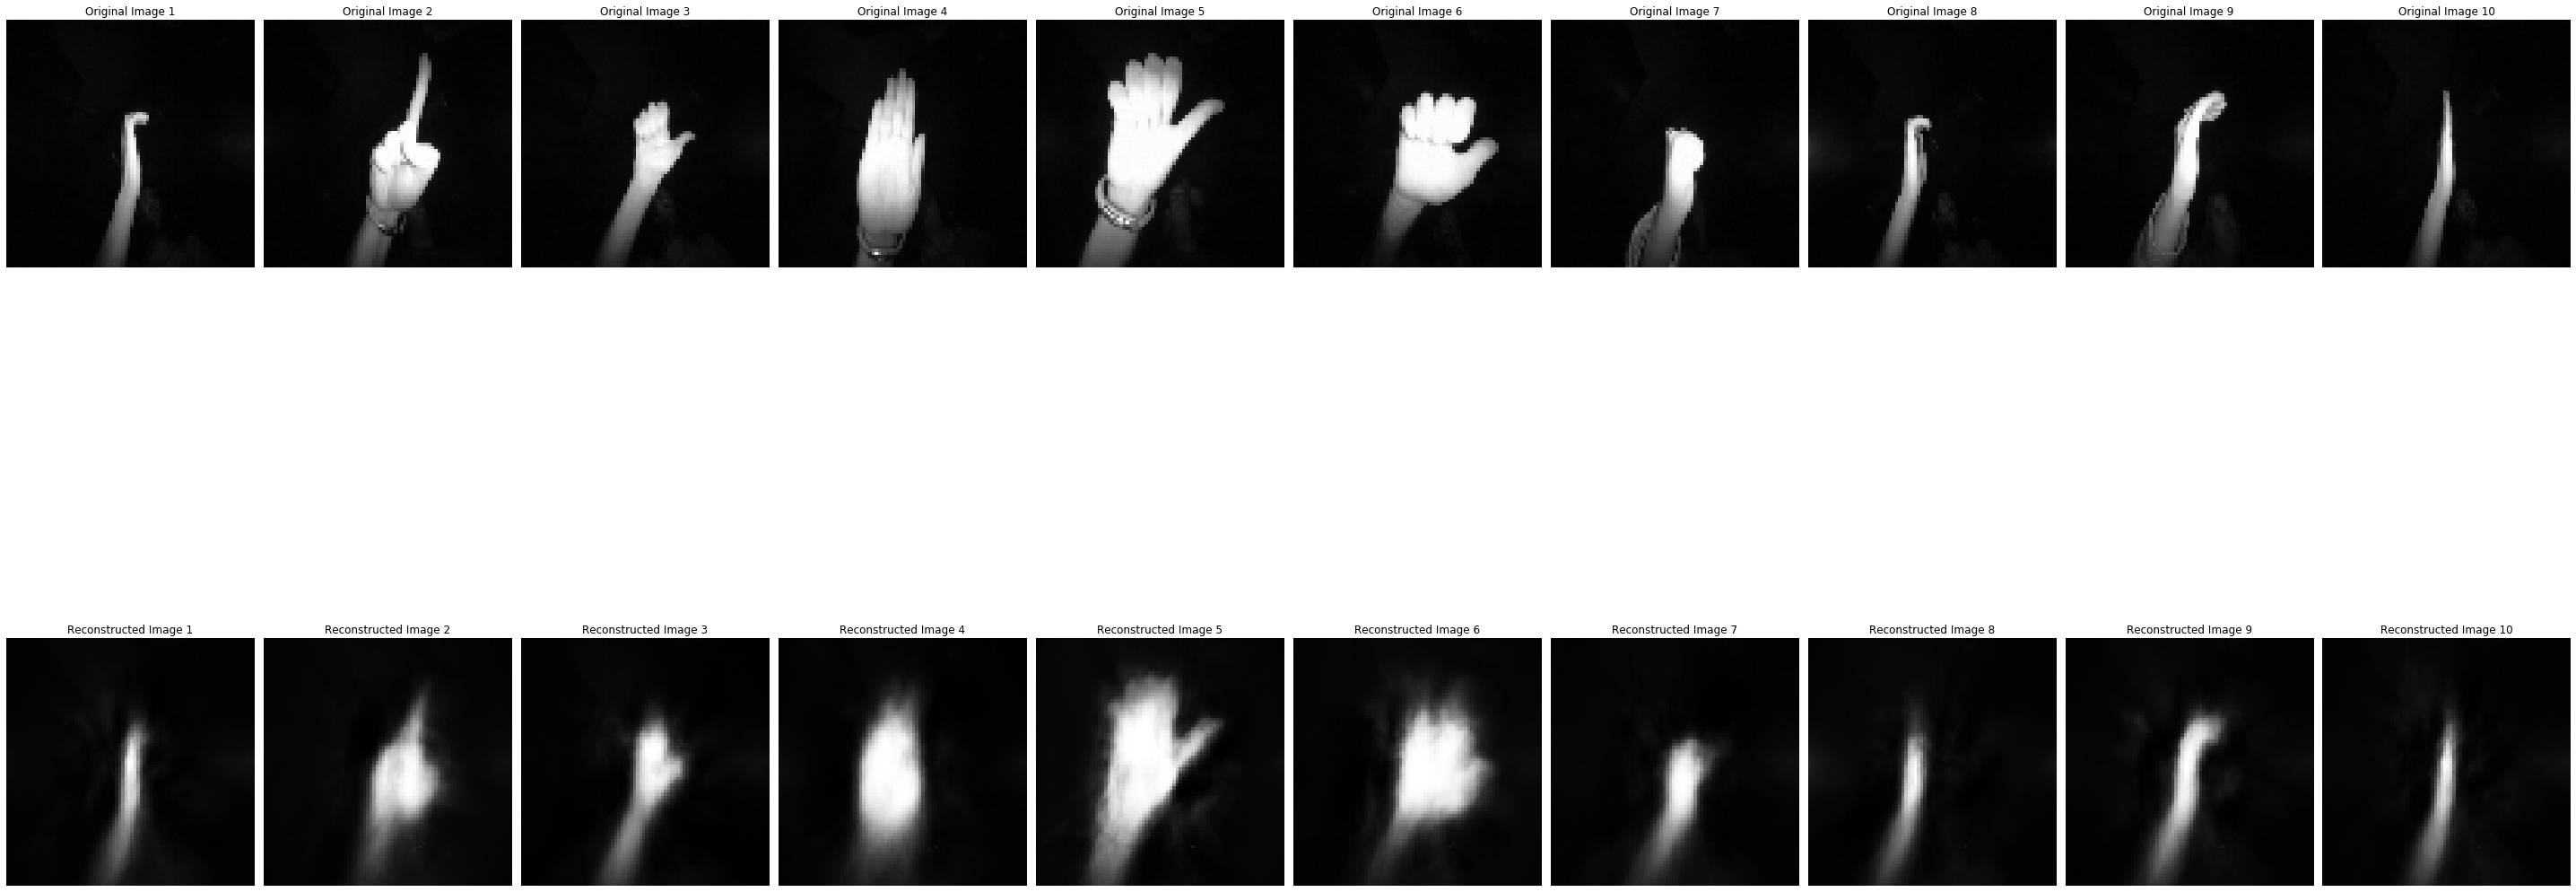

In [19]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error
from skimage.metrics import structural_similarity as ssim
import math
from skimage import exposure  # For contrast enhancement

# Assuming x_val is the test dataset (replace with your test set variable)
# Also assuming autoencoder is your trained model
IMG_SIZE = 80  # Update if needed

# 1. Flatten x_val to match the input shape expected by the autoencoder
x_val_flat = x_val.reshape(x_val.shape[0], -1)  # Flatten each image

# Reconstruct the entire test set
x_test_reconstructed = autoencoder.predict(x_val_flat)

# Reshape the reconstructed images back to the original image shape
x_test_reconstructed = x_test_reconstructed.reshape(x_val.shape)  # Shape should be (num_samples, IMG_SIZE, IMG_SIZE, 1)

# 2. Flatten the images for MSE, MAE, and PSNR calculation
x_test_flat = x_val.reshape(-1, IMG_SIZE * IMG_SIZE)
x_test_reconstructed_flat = x_test_reconstructed.reshape(-1, IMG_SIZE * IMG_SIZE)

# 1. Mean Squared Error (MSE)
mse = mean_squared_error(x_test_flat, x_test_reconstructed_flat)
print(f"Mean Squared Error (MSE): {mse}")

# 2. Mean Absolute Error (MAE)
mae = mean_absolute_error(x_test_flat, x_test_reconstructed_flat)
print(f"Mean Absolute Error (MAE): {mae}")

# 3. Structural Similarity Index (SSIM)
ssim_values = []
for i in range(x_val.shape[0]):
    ssim_value = ssim(x_val[i].reshape(IMG_SIZE, IMG_SIZE), x_test_reconstructed[i].reshape(IMG_SIZE, IMG_SIZE))
    ssim_values.append(ssim_value)

# Calculate average SSIM over the test set
average_ssim = np.mean(ssim_values)
print(f"Average SSIM: {average_ssim}")

# 4. Peak Signal-to-Noise Ratio (PSNR)
psnr_values = []
for i in range(x_val.shape[0]):
    mse_value = mean_squared_error(x_val[i].reshape(IMG_SIZE * IMG_SIZE), x_test_reconstructed[i].reshape(IMG_SIZE * IMG_SIZE))
    psnr_value = 10 * math.log10(1.0 / mse_value)
    psnr_values.append(psnr_value)

# Calculate average PSNR over the test set
average_psnr = np.mean(psnr_values)
print(f"Average PSNR: {average_psnr}")

# 5. Visual Inspection: Display the original and reconstructed images
num_images_to_display = 10  # Number of images to display
plt.figure(figsize=(40, 25))  # Increase the figure size to make the images larger

for i in range(num_images_to_display):
    original_image = x_val[i].reshape(IMG_SIZE, IMG_SIZE)
    reconstructed_image = x_test_reconstructed[i].reshape(IMG_SIZE, IMG_SIZE)
    
    # Enhance contrast of the reconstructed image for better visibility
    reconstructed_image_enhanced = exposure.rescale_intensity(reconstructed_image, in_range='image', out_range=(0, 255))
    original_image_enhanced = exposure.rescale_intensity(original_image, in_range='image', out_range=(0, 255))
    
    # Display the images
    plt.subplot(2, num_images_to_display, i + 1)
    plt.imshow(original_image_enhanced, cmap='gray')
    plt.title(f"Original Image {i + 1}")
    plt.axis('off')

    plt.subplot(2, num_images_to_display, num_images_to_display + i + 1)
    plt.imshow(reconstructed_image_enhanced, cmap='gray')
    plt.title(f"Reconstructed Image {i + 1}")
    plt.axis('off')

plt.tight_layout()
plt.show()


In [20]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.model_selection import train_test_split
import numpy as np

In [21]:
# Flatten x_data to match the input shape expected by the autoencoder
x_data_flat = x_data.reshape(x_data.shape[0], -1)  # Flatten each image to 2D

# Reconstruct the images using the autoencoder
x_data_reconstructed = autoencoder.predict(x_data_flat)

# Reshape the reconstructed images back to the original image shape
x_data_reconstructed = x_data_reconstructed.reshape(x_data.shape)  # Reshape to (num_samples, IMG_SIZE, IMG_SIZE, 1)

# Flatten the reconstructed images for ML model input
x_data_flat = x_data_reconstructed.reshape(len(x_data_reconstructed), -1)


In [22]:
# Split into training and test sets
x_train, x_test, y_train, y_test = train_test_split(x_data_flat, y_data, test_size=0.2, random_state=42)

In [23]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix

# Initialize the Decision Tree classifier
dt_classifier = DecisionTreeClassifier(random_state=42)

# Train the classifier on the training data
dt_classifier.fit(x_train, y_train)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=42, splitter='best')

In [24]:
y_pred = dt_classifier.predict(x_test)

In [25]:
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')  # 'weighted' for handling multiclass classification
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')
conf_matrix = confusion_matrix(y_test.argmax(axis=1), y_pred.argmax(axis=1))

In [26]:
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print("\nConfusion Matrix:")
print(conf_matrix)

# Display the classification report for a more detailed view
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

Accuracy: 0.9785
Precision: 0.9785
Recall: 0.9785
F1 Score: 0.9785

Confusion Matrix:
[[420   0   0   1   0   0   1   3   4   2]
 [  2 382   1   1   1   0   0   2   2   4]
 [  0   0 406   0   1   1   0   1   2   1]
 [  0   0   4 381   0   0   0   1   1   0]
 [  4   1   1   0 379   0   0   1   2   2]
 [  0   1   4   1   0 396   0   0   0   1]
 [  0   0   0   0   0   2 400   0   2   0]
 [  2   0   1   0   1   0   0 402   0   0]
 [  4   4   0   1   2   1   2   1 375   1]
 [  2   2   0   0   1   0   0   1   2 373]]

Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.97      0.97       431
           1       0.98      0.97      0.97       395
           2       0.97      0.99      0.98       412
           3       0.99      0.98      0.99       387
           4       0.98      0.97      0.98       390
           5       0.99      0.98      0.99       403
           6       0.99      0.99      0.99       404
           7       0.98   

In [27]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix

# Initialize the SVM classifier with an RBF kernel
svm_classifier = SVC(kernel='rbf', random_state=42)

# Train the classifier on the training data
svm_classifier.fit(x_train, y_train.argmax(axis=1)) 

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=42, shrinking=True, tol=0.001,
    verbose=False)

In [32]:
y_pred = svm_classifier.predict(x_test)

In [33]:
accuracy = accuracy_score(y_test.argmax(axis=1), y_pred)
precision = precision_score(y_test.argmax(axis=1), y_pred, average='weighted')
recall = recall_score(y_test.argmax(axis=1), y_pred, average='weighted')
f1 = f1_score(y_test.argmax(axis=1), y_pred, average='weighted')
conf_matrix = confusion_matrix(y_test.argmax(axis=1), y_pred)

In [34]:
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print("\nConfusion Matrix:")
print(conf_matrix)

Accuracy: 0.9802
Precision: 0.9812
Recall: 0.9802
F1 Score: 0.9802

Confusion Matrix:
[[417   0   1   0   0   0   0   0  12   1]
 [  1 390   0   0   0   2   0   0   0   2]
 [  0   1 371   0   0  40   0   0   0   0]
 [  0   0   0 387   0   0   0   0   0   0]
 [  0   2   3   0 382   0   0   1   0   2]
 [  0   0   0   0   0 403   0   0   0   0]
 [  0   0   0   0   0   0 403   0   1   0]
 [  0   0   0   0   0   0   0 406   0   0]
 [  2   6   0   0   0   0   0   0 383   0]
 [  0   1   1   0   0   0   0   0   0 379]]


In [35]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix

# Initialize the KNN classifier with an optimal number of neighbors
knn_classifier = KNeighborsClassifier(n_neighbors=5)

# Train the classifier on the training data
knn_classifier.fit(x_train, y_train.argmax(axis=1))

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')

In [36]:
y_pred = knn_classifier.predict(x_test)

In [37]:
accuracy = accuracy_score(y_test.argmax(axis=1), y_pred)
precision = precision_score(y_test.argmax(axis=1), y_pred, average='weighted')
recall = recall_score(y_test.argmax(axis=1), y_pred, average='weighted')
f1 = f1_score(y_test.argmax(axis=1), y_pred, average='weighted')
conf_matrix = confusion_matrix(y_test.argmax(axis=1), y_pred)

In [38]:
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print("\nConfusion Matrix:")
print(conf_matrix)

# Display the classification report for a more detailed view
print("\nClassification Report:")
print(classification_report(y_test.argmax(axis=1), y_pred))

Accuracy: 0.9978
Precision: 0.9977
Recall: 0.9978
F1 Score: 0.9977

Confusion Matrix:
[[428   0   0   0   0   0   0   0   3   0]
 [  0 395   0   0   0   0   0   0   0   0]
 [  0   0 412   0   0   0   0   0   0   0]
 [  0   0   0 387   0   0   0   0   0   0]
 [  0   0   0   0 390   0   0   0   0   0]
 [  0   0   0   0   0 403   0   0   0   0]
 [  0   0   0   0   0   0 404   0   0   0]
 [  0   0   0   0   0   0   0 406   0   0]
 [  3   1   0   0   0   0   1   0 386   0]
 [  0   1   0   0   0   0   0   0   0 380]]

Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       431
           1       0.99      1.00      1.00       395
           2       1.00      1.00      1.00       412
           3       1.00      1.00      1.00       387
           4       1.00      1.00      1.00       390
           5       1.00      1.00      1.00       403
           6       1.00      1.00      1.00       404
           7       1.00   

In [39]:
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix

# Initialize the MLP classifier
mlp_classifier = MLPClassifier(hidden_layer_sizes=(128, 64), max_iter=500, activation='relu', solver='adam', random_state=42)

# Train the classifier on the training data
mlp_classifier.fit(x_train.reshape(len(x_train), -1), y_train.argmax(axis=1)) 

MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(128, 64), learning_rate='constant',
              learning_rate_init=0.001, max_fun=15000, max_iter=500,
              momentum=0.9, n_iter_no_change=10, nesterovs_momentum=True,
              power_t=0.5, random_state=42, shuffle=True, solver='adam',
              tol=0.0001, validation_fraction=0.1, verbose=False,
              warm_start=False)

In [40]:
y_pred = mlp_classifier.predict(x_test.reshape(len(x_test), -1))

In [41]:
accuracy = accuracy_score(y_test.argmax(axis=1), y_pred)
precision = precision_score(y_test.argmax(axis=1), y_pred, average='weighted')
recall = recall_score(y_test.argmax(axis=1), y_pred, average='weighted')
f1 = f1_score(y_test.argmax(axis=1), y_pred, average='weighted')
conf_matrix = confusion_matrix(y_test.argmax(axis=1), y_pred)

In [43]:
# Display metrics
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print("\nConfusion Matrix:")
print(conf_matrix)

# Display the classification report for a more detailed view
print("\nClassification Report:")
print(classification_report(y_test.argmax(axis=1), y_pred))

Accuracy: 0.9968
Precision: 0.9968
Recall: 0.9968
F1 Score: 0.9968

Confusion Matrix:
[[426   0   0   0   0   0   0   0   5   0]
 [  0 394   1   0   0   0   0   0   0   0]
 [  0   0 412   0   0   0   0   0   0   0]
 [  0   0   0 387   0   0   0   0   0   0]
 [  1   0   0   0 389   0   0   0   0   0]
 [  0   0   0   0   0 403   0   0   0   0]
 [  0   0   1   0   0   0 403   0   0   0]
 [  0   0   0   1   0   0   0 405   0   0]
 [  0   0   2   0   0   0   0   0 389   0]
 [  0   0   2   0   0   0   0   0   0 379]]

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.99      0.99       431
           1       1.00      1.00      1.00       395
           2       0.99      1.00      0.99       412
           3       1.00      1.00      1.00       387
           4       1.00      1.00      1.00       390
           5       1.00      1.00      1.00       403
           6       1.00      1.00      1.00       404
           7       1.00   